<a href="https://colab.research.google.com/github/Pingxia/ConvolutionalSketchInversion/blob/master/sketchreal_v3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Adapted from Sketchback: Convolutional Sketch Inversion using Keras
https://github.com/BKHMSI/Sketchback/blob/master/sketchback.ipynb

GAN is implemented on top of Sketchback.

In [0]:
from __future__ import print_function
import numpy as np
import pandas as pd 
import cv2 as cv
import time
import os
import h5py
import matplotlib.pyplot as plt
import scipy.misc
import scipy.ndimage

from tqdm import tqdm
from copy import deepcopy
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Convolution2D, Deconvolution2D, add
from keras.layers.core import Activation, Dropout, Flatten, Lambda
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam, Nadam
from keras.utils import np_utils, plot_model
from keras.callbacks import TensorBoard
from keras import objectives, layers
from keras.applications import vgg16
from keras.applications.vgg16 import preprocess_input
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from skimage.transform import resize

np.random.seed(5242)  # for reproducibility

Using TensorFlow backend.


In [0]:
m = 504
n = 400
sketch_dim = (m,n)
img_dim = (m,n,3)
num_images = 150
num_epochs = 25
batch_size = 10
file_names = []

# CUHK_SKETCH_PATH = 'dataset_v3/CUHK_sketch'
# CUHK_IMAGE_PATH = 'dataset_v3/CUHK_photo'
# FERET_SKETCH_PATH = 'dataset_v3/FERET_sketch'
# FERET_IMAGE_PATH = 'dataset_v3/FERET_photo'
CUHK_SKETCH_PATH = '/content/drive/My Drive/CS5242/CUHK/CUHK_train_sketch'
CUHK_IMAGE_PATH = '/content/drive/My Drive/CS5242/CUHK/CUHK_train_photo'

# CUHK_SKETCH_PATH = 'dataset/CUHK_train_sketch_v2'
# CUHK_IMAGE_PATH = 'dataset/CUHK_train_photo_v2'

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
def load_file_names(path):
    list_of_file_names = os.listdir(path)
    list_of_file_names.sort() #sorts in place
    return list_of_file_names

In [0]:
def sub_plot(x,y,z):
    fig = plt.figure()
    a = fig.add_subplot(1,3,1)
    imgplot = plt.imshow(x, cmap='gray')
    a.set_title('Sketch')
    plt.axis("off")
    a = fig.add_subplot(1,3,2)
    imgplot = plt.imshow(z)
    a.set_title('Prediction')
    plt.axis("off")
    a = fig.add_subplot(1,3,3)
    imgplot = plt.imshow(y)
    a.set_title('Ground Truth')
    plt.axis("off")
    plt.show()

In [0]:
def imshow(x, gray=False):
    plt.imshow(x, cmap='gray' if gray else None)
    plt.show()

In [0]:
def get_batch(idx, X = True, Y = True, W = True, dataset=['cuhk']):
    X_file_names = []
    Y_file_names = []

    X_train = np.zeros((batch_size, m, n), dtype='float32')
    Y_train = np.zeros((batch_size, m, n, 3), dtype='float32')
    F_train = None
    
    for data in dataset:
        if data == 'cuhk':
            x_path = CUHK_SKETCH_PATH
            y_path = CUHK_IMAGE_PATH
        else: # data == 'feret':
            x_path = FERET_SKETCH_PATH
            y_path = FERET_IMAGE_PATH
        if X:
            file_names = [x_path + "/" + s for s in load_file_names(x_path)]
            X_file_names.extend(file_names)
        if Y:
            file_names = [y_path + "/" + s for s in load_file_names(y_path)]
            Y_file_names.extend(file_names)
            
#         print("at", data, "current total X:", len(X_file_names), "current total Y:", len(Y_file_names))

#     print("X_file_names:", X_file_names)
#     print("Y_file_names:", Y_file_names)

    ###############
    if len(X_file_names) != 0:
        # Load Sketches
        for i in range(batch_size):
            if ((i+batch_size*idx) > (len(file_names)-1)):
                break
            file = X_file_names[i+batch_size*idx]
            img = cv.imread(file,0)
            img = resize(img, sketch_dim)
            img = img.astype('float32')
            X_train[i] = img #/ 255.

    if len(Y_file_names) != 0:
        # Load Ground-truth Images
        for i in range(batch_size):
            if ((i+batch_size*idx) > (len(file_names)-1)):
                break
            file = Y_file_names[i+batch_size*idx]
            img = cv.imread(file)
            img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
            img = resize(img, img_dim)
            img = img.astype('float32')
            # cannot normalise somehow...
            Y_train[i] = img # / 255. 
    if W:
        F_train = get_features(Y_train)

    X_train = np.reshape(X_train, (batch_size, m, n, 1))
    ###############
    return X_train, Y_train, F_train

In [0]:
def get_features(Y):
    base_model = vgg16.VGG16(weights='imagenet', include_top=False)
    vgg = Model(inputs=base_model.input, outputs=base_model.get_layer('block2_conv2').output)
    Z = deepcopy(Y)
    Z = preprocess_vgg(Z)
    features = vgg.predict(Z, batch_size = 5, verbose = 0)
    return features

In [0]:
def preprocess_vgg(x, data_format=None):
    if data_format is None:
        data_format = K.image_data_format()
    assert data_format in {'channels_last', 'channels_first'}
    x = 255. * x
    if data_format == 'channels_first':
        # 'RGB'->'BGR'
        x = x[:, ::-1, :, :]
        # Zero-center by mean pixel
        x[:, 0, :, :] = x[:, 0, :, :] - 103.939
        x[:, 1, :, :] = x[:, 1, :, :] - 116.779
        x[:, 2, :, :] = x[:, 2, :, :] - 123.68
    else:
        # 'RGB'->'BGR'
        x = x[:, :, :, ::-1]
        # Zero-center by mean pixel
        x[:, :, :, 0] = x[:, :, :, 0] - 103.939
        x[:, :, :, 1] = x[:, :, :, 1] - 116.779
        x[:, :, :, 2] = x[:, :, :, 2] - 123.68
    return x

In [0]:
def feature_loss(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

def pixel_loss(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred))) + 0.00001*total_variation_loss(y_pred)

def adv_loss(y_true, y_pred):
    return K.mean(K.binary_crossentropy(y_pred, y_true), axis=-1)

def total_variation_loss(y_pred):
    if K.image_data_format() == 'channels_first':
        a = K.square(y_pred[:, :, :m - 1, :n - 1] - y_pred[:, :, 1:, :n - 1])
        b = K.square(y_pred[:, :, :m - 1, :n - 1] - y_pred[:, :, :m - 1, 1:])
    else:
        a = K.square(y_pred[:, :m - 1, :n - 1, :] - y_pred[:, 1:, :n - 1, :])
        b = K.square(y_pred[:, :m - 1, :n - 1, :] - y_pred[:, :m - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [0]:
def preprocess_VGG(x, dim_ordering='default'):
    if dim_ordering == 'default':
        dim_ordering = K.image_dim_ordering()
    assert dim_ordering in {'tf', 'th'}
    # x has pixels intensities between 0 and 1
    x = 255. * x
    norm_vec = K.variable([103.939, 116.779, 123.68])
    if dim_ordering == 'th':
        norm_vec = K.reshape(norm_vec, (1,3,1,1))
        x = x - norm_vec
        # 'RGB'->'BGR'
        x = x[:, ::-1, :, :]
    else:
        norm_vec = K.reshape(norm_vec, (1,1,1,3))
        x = x - norm_vec
        # 'RGB'->'BGR'
        x = x[:, :, :, ::-1]
    return x

In [0]:
def generator_model(input_img):

    # Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = Conv2D(32, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(64, (2, 2), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
    res = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])
    res = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.add([x, res])

    # Decoder
    res = Conv2D(256, (3, 3), activation='relu', padding='same', name='block5_conv1')(encoded)
    x = layers.add([encoded, res])
    res = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])
    res = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])

    x = Conv2D(128, (2, 2), activation='relu', padding='same', name='block6_conv1')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block7_conv1')(x)
    res = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])
    res = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])

    x = Conv2D(64, (2, 2), activation='relu', padding='same', name='block8_conv1')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block9_conv1')(x)
    res = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])
    res = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])

    x = Conv2D(32, (2, 2), activation='relu', padding='same', name='block10_conv1')(x)
    x = UpSampling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same', name='block11_conv1')(x)
    res = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.add([x, res])
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    
    print("decoded:",decoded)
    return decoded

In [0]:
def generator_model_2(input_img):
    x = Convolution2D(32, (9, 9), padding="same", strides=(1,1))(input_img)
    x = BatchNormalization(axis=1)(x)
    x = Activation("relu")(x)
    
    x = Convolution2D(64, (3, 3), padding="same", strides=(2,2))(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation("relu")(x)
    
    x = Convolution2D(128, (3, 3), padding="same", strides=(2,2))(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation("relu")(x)
    
    # then 5 res blocks
    r = Convolution2D(128, (3, 3), padding="same")(x)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    r = Convolution2D(128, (3, 3), padding="same")(r)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    # Merge residual and identity
    x = add([x, r])
    
    r = Convolution2D(128, (3, 3), padding="same")(x)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    r = Convolution2D(128, (3, 3), padding="same")(r)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    # Merge residual and identity
    x = add([x, r])
    
    r = Convolution2D(128, (3, 3), padding="same")(x)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    r = Convolution2D(128, (3, 3), padding="same")(r)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    # Merge residual and identity
    x = add([x, r])
              
    r = Convolution2D(128, (3, 3), padding="same")(x)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    r = Convolution2D(128, (3, 3), padding="same")(r)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    # Merge residual and identity
    x = add([x, r])
    
    r = Convolution2D(128, (3, 3), padding="same")(x)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    r = Convolution2D(128, (3, 3), padding="same")(r)
    r = BatchNormalization(axis=1)(r)
    r = Activation("relu")(r)
    # Merge residual and identity
    x = add([x, r])
    
    # the 2 deconv blocks
    x = Deconvolution2D(64, (3, 3), output_shape=(batch_size, m/2, n/2, 64), padding='same', strides=(2,2))(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation("relu")(x)
    
    x = Deconvolution2D(32, (3, 3), output_shape=(batch_size, m/2, n/2, 32), padding='same', strides=(2,2))(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation("relu")(x)

    # final conv block
    x = Convolution2D(3, (9, 9), padding="same", strides=(1,1))(x)
    x = BatchNormalization(axis=1)(x)
    x = Activation("sigmoid")(x)
    
    return x

In [0]:
def discriminator_model(img_input):
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='d_block1_conv1')(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='d_block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='d_block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='d_block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='d_block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='d_block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='d_block3_conv1')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='d_block3_conv2')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='d_block3_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='d_block3_pool')(x)

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='d_block4_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='d_block4_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='d_block4_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='d_block4_pool')(x)

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='d_block5_conv1')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='d_block5_conv2')(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='d_block5_conv3')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='d_block5_pool')(x)
    
    x = Flatten(name='flatten')(x)
    x = Dense(512, activation='relu', name='d_fc1')(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='relu', name='d_fc2')(x)
    model = Model(inputs=img_input, outputs=x)
    
    return model

In [0]:
def feat_model(img_input):
    # extract vgg feature
    vgg_16 = vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=None)
    # freeze VGG_16 when training
    for layer in vgg_16.layers:
        layer.trainable = False
    
    vgg_first2 = Model(inputs=vgg_16.input, outputs=vgg_16.get_layer('block2_conv2').output)
    Norm_layer = Lambda(preprocess_VGG)
    x_VGG = Norm_layer(img_input)
    feat = vgg_first2(x_VGG)
    print("feat:",feat)
    return feat

In [0]:
def full_model(summary = True):
    input_img = Input(shape=(m, n, 1))
    generator = generator_model(input_img)
    feat = feat_model(generator)
    model = Model(inputs=input_img, outputs=[generator, feat], name='sketch_inversion')
    
    model.summary()
    return model

In [0]:
def full_model_2(summary = True):
    input_img = Input(shape=(m, n, 1))
    
    generator = generator_model_2(input_img)
    feat = feat_model(generator)
    model = Model(inputs=input_img, outputs=[generator, feat], name='sketch_inversion')
    
    model.summary()
    return model

In [0]:
def write_log(callback, name, value, batch_no):
    summary = tf.Summary()
    summary_value = summary.value.add()
    summary_value.simple_value = value
    summary_value.tag = name
    callback.writer.add_summary(summary, batch_no)
    callback.writer.flush()

# Generative Adversarial Networks Model
## Referencing paper "Scribbler: Controlling Deep Image Synthesis with Sketch and Color"
by Patsorn Sangkloy, Jingwan Lu, Chen Fang, Fisher Yu, and James Hays

In [0]:
gan_start_time = time.time()

# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

optim = Adam(lr=1e-4,beta_1=0.9, beta_2=0.999, epsilon=1e-8)

# discriminator model
discriminator = discriminator_model(Input(shape=(m, n, 3)))
discriminator.compile(loss='binary_crossentropy',optimizer=optim, metrics=['accuracy'])
discriminator.trainable=True
discriminator.summary()

# generator model
input_img = Input(shape=(m, n, 1))
generator = generator_model(input_img)
gen_model = Model(input=input_img, output=generator, name='gen_model')
gen_model.summary()

# feature model
feat = feat_model(generator)

# combined model, freeze discriminator
discriminator.trainable=False
img = gen_model(input_img)
dis_img = discriminator(img)

# 1st version, with only adv_loss
# combined_model = Model(input=input_img, outputs=dis_img, name='architect')
# combined_model.compile(loss= adv_loss, optimizer=optim)

# 2nd version, with adv_loss and pixel loss
# combined_model = Model(input=input_img, outputs=[img, dis_img], name='architect')
# combined_model.compile(loss= [pixel_loss, adv_loss],loss_weights=[1, 0.01], optimizer=optim)

# 3rd version, with adv_loss, pixel loss and feature loss
combined_model = Model(input=input_img, output=[img, feat, dis_img], name='architect')
combined_model.compile(loss= [pixel_loss, feature_loss, 'binary_crossentropy'],
                       loss_weights=[1, 0.01, 0.1], optimizer=optim)

# Original: with pixel loss and feature loss only
# combined_model = Model(input=input_img, output=[img, feat], name='architect')
# combined_model.compile(loss= [pixel_loss, feature_loss],loss_weights=[1, 0.01], optimizer=optim)

combined_model.summary()
        
log_path = '/content/drive/My Drive/CS5242/logs'
callback = TensorBoard(log_path)
callback.set_model(combined_model)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 504, 400, 3)       0         
_________________________________________________________________
d_block1_conv1 (Conv2D)      (None, 504, 400, 64)      1792      
_________________________________________________________________
d_block1_conv2 (Conv2D)      (None, 504, 400, 64)      36928     
_________________________________________________________________
d_block1_pool (MaxPooling2D) (None, 252, 200, 64)      0         
_________________________________________________________________
d_block2_conv1 (Conv2D)      (None, 252, 200, 128)     73856     
_________________________________________________________________
d_block2_conv2 (Conv2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="gen_model", inputs=Tensor("in..., outputs=Tensor("co...)`


feat: Tensor("model_2/block2_conv2/Relu:0", shape=(?, 252, 200, 128), dtype=float32)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="architect", inputs=Tensor("in..., outputs=[<tf.Tenso...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 504, 400, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 504, 400, 32) 320         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 504, 400, 32) 4128        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 252, 200, 32) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
block2_con

In [0]:
for epoch in range(num_epochs):
    num_batches = num_images // batch_size

    for batch in range(num_batches):
        # Y: real images
        X,Y,W = get_batch(batch, dataset=['cuhk'])
#         X,Y,W = get_batch(batch, dataset=['cuhk'])
        # Y_pred: fake images
        Y_pred = gen_model.predict(X) 

        # Train the discriminator (real classified as ones and generated as zeros)
        d_loss_real = discriminator.train_on_batch(Y, valid)
        d_loss_fake = discriminator.train_on_batch(Y_pred, fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train combined_model model
        # 1st version
        # g_loss = combined_model.train_on_batch(X, valid)
        # 2nd version
        # g_loss = combined_model.train_on_batch(X, [Y,valid])
        # 3rd version
        g_loss = combined_model.train_on_batch(X, [Y,W,valid])
        # original
#         g_loss = combined_model.train_on_batch(X, [Y,W])
        
        print ("epoch: " + str(epoch) + ", batch:" + str(batch) + ", D loss: " + str(d_loss) + ", G loss: " + str(g_loss) 
                + ", D loss real: " + str(d_loss_real) + ", D loss fake: " + str(d_loss_fake))
    
    write_log(callback, 'total_loss', g_loss[0], epoch)
    write_log(callback, 'pixel_loss', g_loss[1], epoch)
    write_log(callback, 'feature_loss', g_loss[2], epoch)
    write_log(callback, 'adversarial_loss', g_loss[3], epoch)


#     discriminator.save_weights("discriminator_weights_%d" % epoch)
#     gen_model.save_weights("gen_weights_%d" % epoch)
#     combined_model.save_weights("combined_model_%d" % epoch)
print("time taken: ", time.time() - gan_start_time)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [0]:
combined_model.save("/content/drive/My Drive/CS5242/model_GAN_" + str(time.time()) + ".h5")
model = combined_model

# Prediction for GAN Model

In [0]:
# Trained with CUHK v2, best model so far, 30 epochs
# model = load_model("model_1554567513.8089657.h5",  
#                    custom_objects={'pixel_loss': pixel_loss, 'feature_loss' : feature_loss})

# model = load_model("model_1554643885.0671806.h5",  
#                    custom_objects={'pixel_loss': pixel_loss, 'feature_loss' : feature_loss})

# model = load_model("model_1554786205.173943.h5",   #test if it still works
#                    custom_objects={'pixel_loss': pixel_loss, 'feature_loss' : feature_loss})

# # using feret original as training set
# model = load_model("model_1554939815.8514454.h5",
#                    custom_objects={'pixel_loss': pixel_loss, 'feature_loss' : feature_loss})


model = load_model("/content/drive/My Drive/CS5242/model_GAN_1555315737.2929273.h5",
                   custom_objects={'pixel_loss': pixel_loss, 'feature_loss' : feature_loss})

# Trained with CUHK v2, with 40 epochs


Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [0]:
X, T, _ = get_batch(0, Y = True, W = False, dataset=['cuhk'])
Y = model.predict(X[:5])[0] #difference btn GAN n Gen only

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


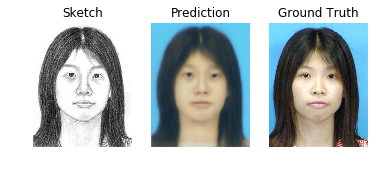

In [0]:
i = 0
x = X[i].reshape(m,n)
y = Y[i]
sub_plot(x, T[i], y)

In [0]:
sketch = cv.imread('dataset_v4/CUHK_test_sketch/f-040-01-sz1.jpg', 0)
sketch = resize(sketch, sketch_dim)
#sketch = sketch / 255.
sketch = sketch.reshape(1,m,n,1)

In [0]:
result = model.predict(sketch)[0]
imshow(result[0])

In [0]:
fig = plt.figure()
a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(sketch[0].reshape(m,n), cmap='gray')
a.set_title('Sketch')
plt.axis("off")
a = fig.add_subplot(1,2,2)
imgplot = plt.imshow(result[0])
a.set_title('Prediction')
plt.axis("off")
plt.show()

### Prediction on FERET

In [0]:
sketch = cv.imread('dataset/FERET_sketch/00023.jpg', 0)
sketch = resize(sketch, sketch_dim)
#sketch = sketch / 255.
sketch = sketch.reshape(1,m,n,1)

In [0]:
result = model.predict(sketch)[0]
imshow(result[0])

In [0]:
fig = plt.figure()
a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(sketch[0].reshape(m,n), cmap='gray')
a.set_title('Sketch')
plt.axis("off")
a = fig.add_subplot(1,2,2)
imgplot = plt.imshow(result[0])
a.set_title('Prediction')
plt.axis("off")
plt.show()

### Prediction on Customised Data

In [0]:
# sketch = cv.imread('Test_Images_from_the_Wild/wang_wei_6.1.jpg', 0)
sketch = cv.imread('/content/drive/My Drive/CS5242/2_1.jpg', 0)
sketch = resize(sketch, sketch_dim)
#sketch = sketch / 255.
sketch = sketch.reshape(1,m,n,1)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


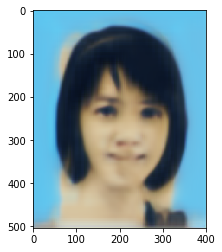

In [0]:
result = model.predict(sketch)[0]
imshow(result[0])

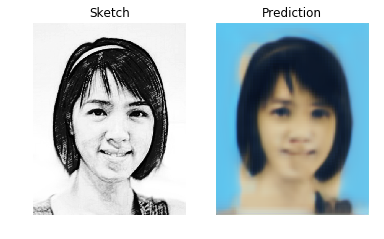

In [0]:
fig = plt.figure()
a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(sketch[0].reshape(m,n), cmap='gray')
a.set_title('Sketch')
plt.axis("off")
a = fig.add_subplot(1,2,2)
imgplot = plt.imshow(result[0])
a.set_title('Prediction')
plt.axis("off")
plt.show()

# Generator Only Model
### Referencing paper "Convolutional Sketch Inversion" 
by Yagmur Gucluturk, Umut Guclu, Rob van Lier, and Marcel A. J. van Gerven

In [0]:
gen_start_time = time.time()
model = full_model()
optim = Adam(lr=1e-4,beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss=[pixel_loss, feature_loss], loss_weights=[1, 0.01], optimizer=optim)

In [0]:
for epoch in range(num_epochs):
    num_batches = num_images // batch_size

    for batch in range(num_batches):
        X,Y,W = get_batch(batch, dataset=['cuhk','feret'])
#         loss = model.fit(X, X, verbose = True, shuffle="batch", epochs = 1, batch_size=batch_size)
        loss = model.train_on_batch(X, [Y, W])
        print("Loss in Epoch # ",epoch,"| Batch #", batch, ":", loss)
        
    model.save_weights("weights/weights_at_epoch_%d" % epoch)

print("time taken: ", time.time() - gen_start_time)

In [0]:
model.save("model_" + str(time.time()) + ".h5")

# Prediction for Generator Only Model

In [0]:
# model = load_model("model_1553832422.8651268.h5",  
#                    custom_objects={'pixel_loss': pixel_loss, 'feature_loss' : feature_loss})

# model = load_model("model_1554582338.5100572.h5",  
#                    custom_objects={'pixel_loss': pixel_loss, 'feature_loss' : feature_loss})

# model = load_model("model_1554655725.0686414.h5",  
#                    custom_objects={'pixel_loss': pixel_loss, 'feature_loss' : feature_loss})

In [0]:
X, T, _ = get_batch(2, X = True, Y = True, W = False, dataset=['cuhk'])
Y, W = model.predict(X[:5])

In [0]:
i = 3
x = X[i].reshape(m,n)
y = Y[i]
sub_plot(x, T[i], y)

In [0]:
sketch = cv.imread('dataset/CUHK_test_sketch_v2/f-039-01-sz1.jpg', 0)
sketch = resize(sketch, sketch_dim)
#sketch = sketch / 255.
sketch = sketch.reshape(1,m,n,1)

In [0]:
result, _ = model.predict(sketch)
imshow(result[0])

In [0]:
fig = plt.figure()
a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(sketch[0].reshape(m,n), cmap='gray')
a.set_title('Sketch')
plt.axis("off")
a = fig.add_subplot(1,2,2)
imgplot = plt.imshow(result[0])
a.set_title('Prediction')
plt.axis("off")
plt.show()

### Prediction on FERET

In [0]:
sketch = cv.imread('dataset/FERET_sketch/00023.jpg', 0)
sketch = resize(sketch, sketch_dim)
#sketch = sketch / 255.
sketch = sketch.reshape(1,m,n,1)

In [0]:
result, _ = model.predict(sketch)
imshow(result[0])

In [0]:
fig = plt.figure()
a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(sketch[0].reshape(m,n), cmap='gray')
a.set_title('Sketch')
plt.axis("off")
a = fig.add_subplot(1,2,2)
imgplot = plt.imshow(result[0])
a.set_title('Prediction')
plt.axis("off")
plt.show()

### Prediction on Customised Data

In [0]:
sketch = cv.imread('dataset/customised_test_sketch/wang_wei_6.1.jpg', 0)
sketch = resize(sketch, sketch_dim)
#sketch = sketch / 255.
sketch = sketch.reshape(1,m,n,1)

In [0]:
result, _ = model.predict(sketch)
imshow(result[0])

In [0]:
fig = plt.figure()
a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(sketch[0].reshape(m,n), cmap='gray')
a.set_title('Sketch')
plt.axis("off")
a = fig.add_subplot(1,2,2)
imgplot = plt.imshow(result[0])
a.set_title('Prediction')
plt.axis("off")
plt.show()